In [16]:
import pandas as pd
import nltk
import json  
import sys  
import numpy as np

import seaborn as sns  
import matplotlib.pyplot as plt  
from sklearn.manifold import TSNE  
from sklearn.decomposition import PCA  
import random  

from transformers import AutoImageProcessor, ResNetForImageClassification  
import torch  
from PIL import Image  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  

import torch  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score  
import pandas as pd  
from PIL import Image  
from torchvision import transforms  
from tqdm import tqdm  

In [17]:
df = pd.read_csv("./../input/df_cleaned_v2.csv")

In [18]:
def modify_labels(y_true, y_pred):  
    """  
    Modifies the predicted values based on the confusion matrix.  
    """  
    cm = confusion_matrix(y_true, y_pred)  
    n_classes = len(np.unique(y_true))  
    modified_pred = np.copy(y_pred)
    
    mapping = {}
    for true_label in range(n_classes): 
        max_count = -1  
        for pred_label in range(n_classes):
            if cm[true_label, pred_label] > max_count and pred_label not in mapping.values():  
                max_count = cm[true_label, pred_label]
                mapping[true_label] = pred_label
        
        # print(mapping)
        # # print(mapping)
        # print(f"Replace y_pred {mapping[true_label]} by {true_label}, because {max_count}")
        # print()
    for true_label, pred_label in mapping.items():  
         modified_pred[y_pred == pred_label] = true_label
        
    return modified_pred

# Texte

Analyse veille sur le texte, je regarde sur les classifieur de text en tendance sur HuggingFace.

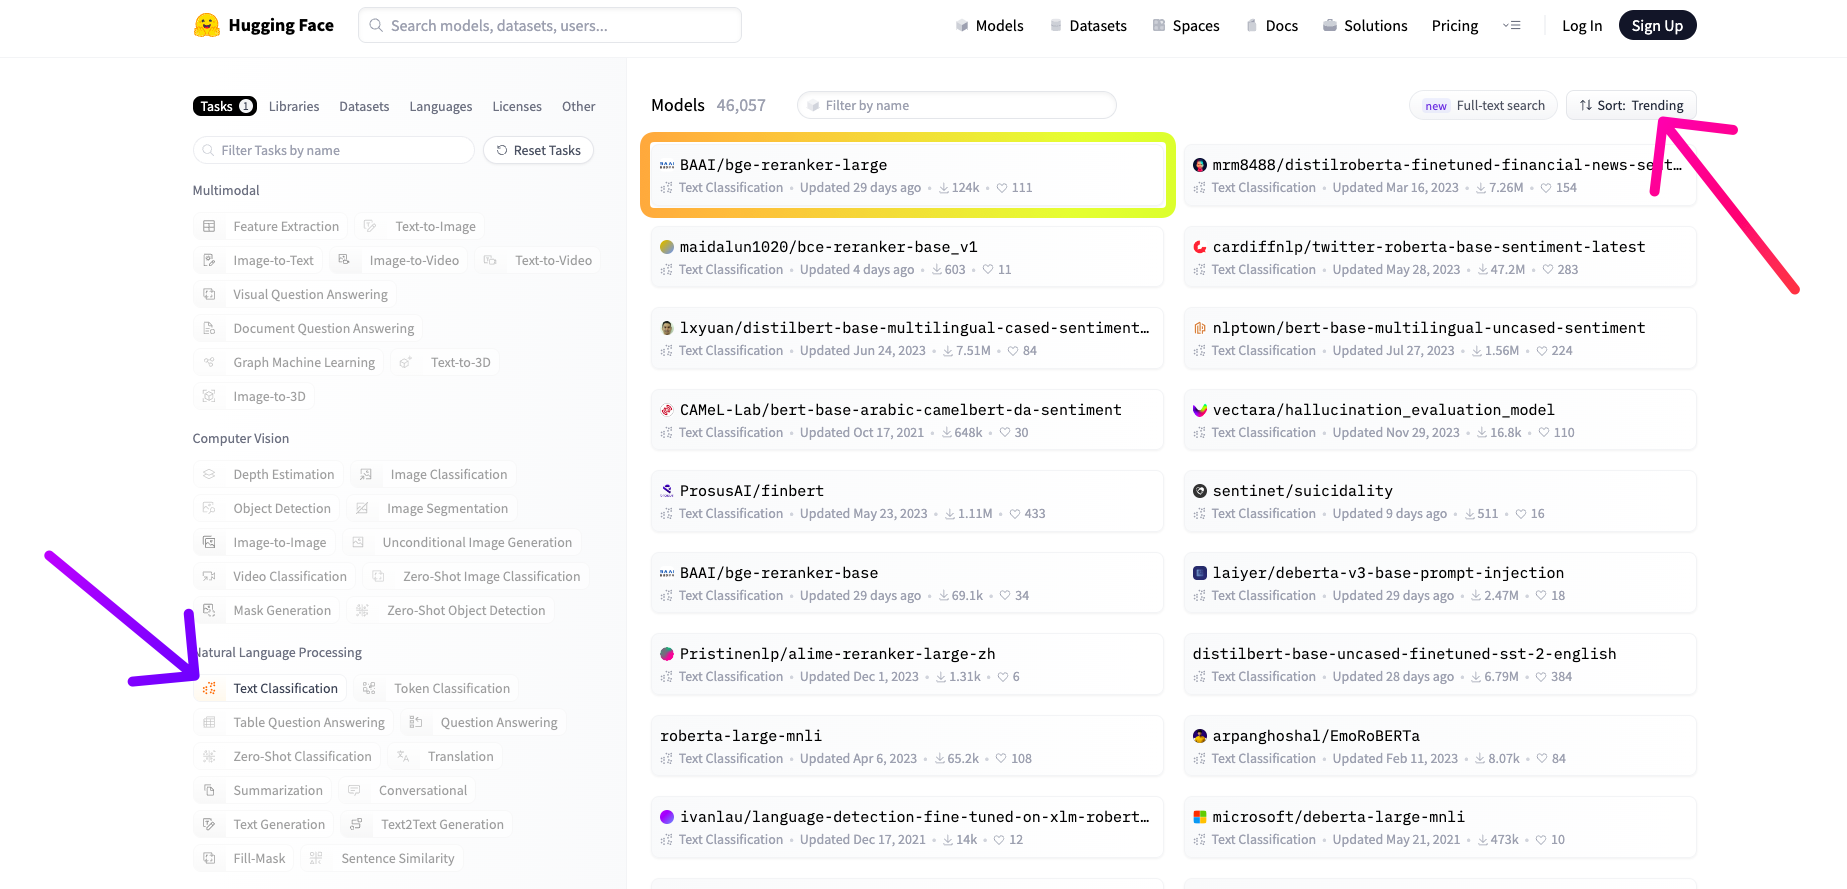

Et je décide de les comparer par rapport au classement des meilleurs classifieurs de textes avec MTEB

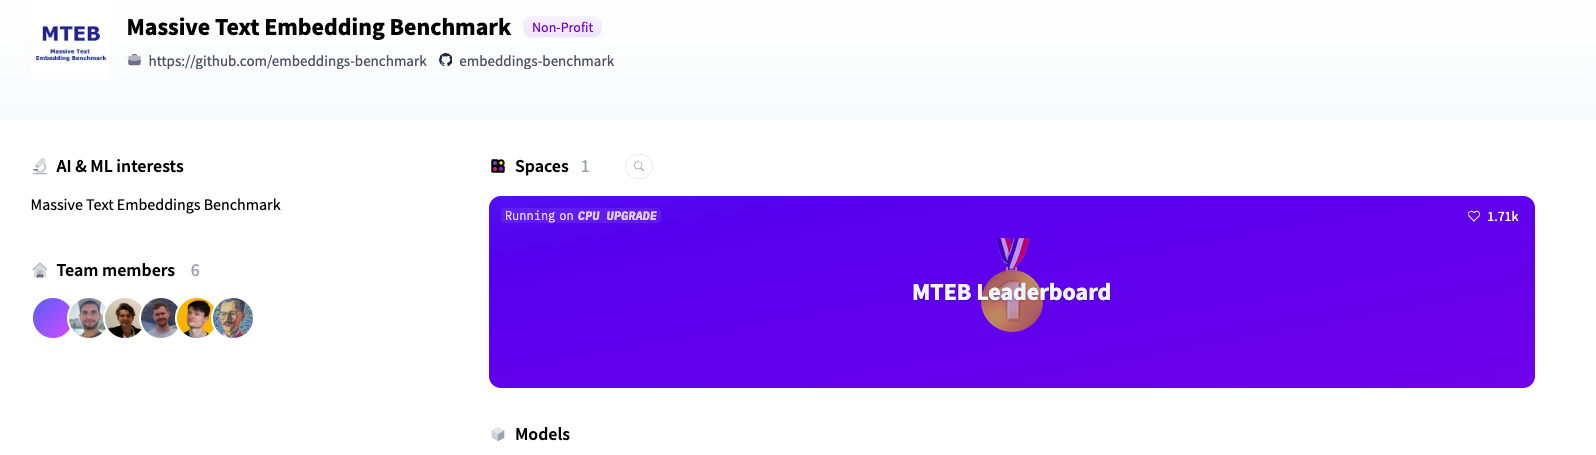

Pour ma machine, j'utiliose la version bge-base-en-v1.5 qui est classé 7e, pas mal

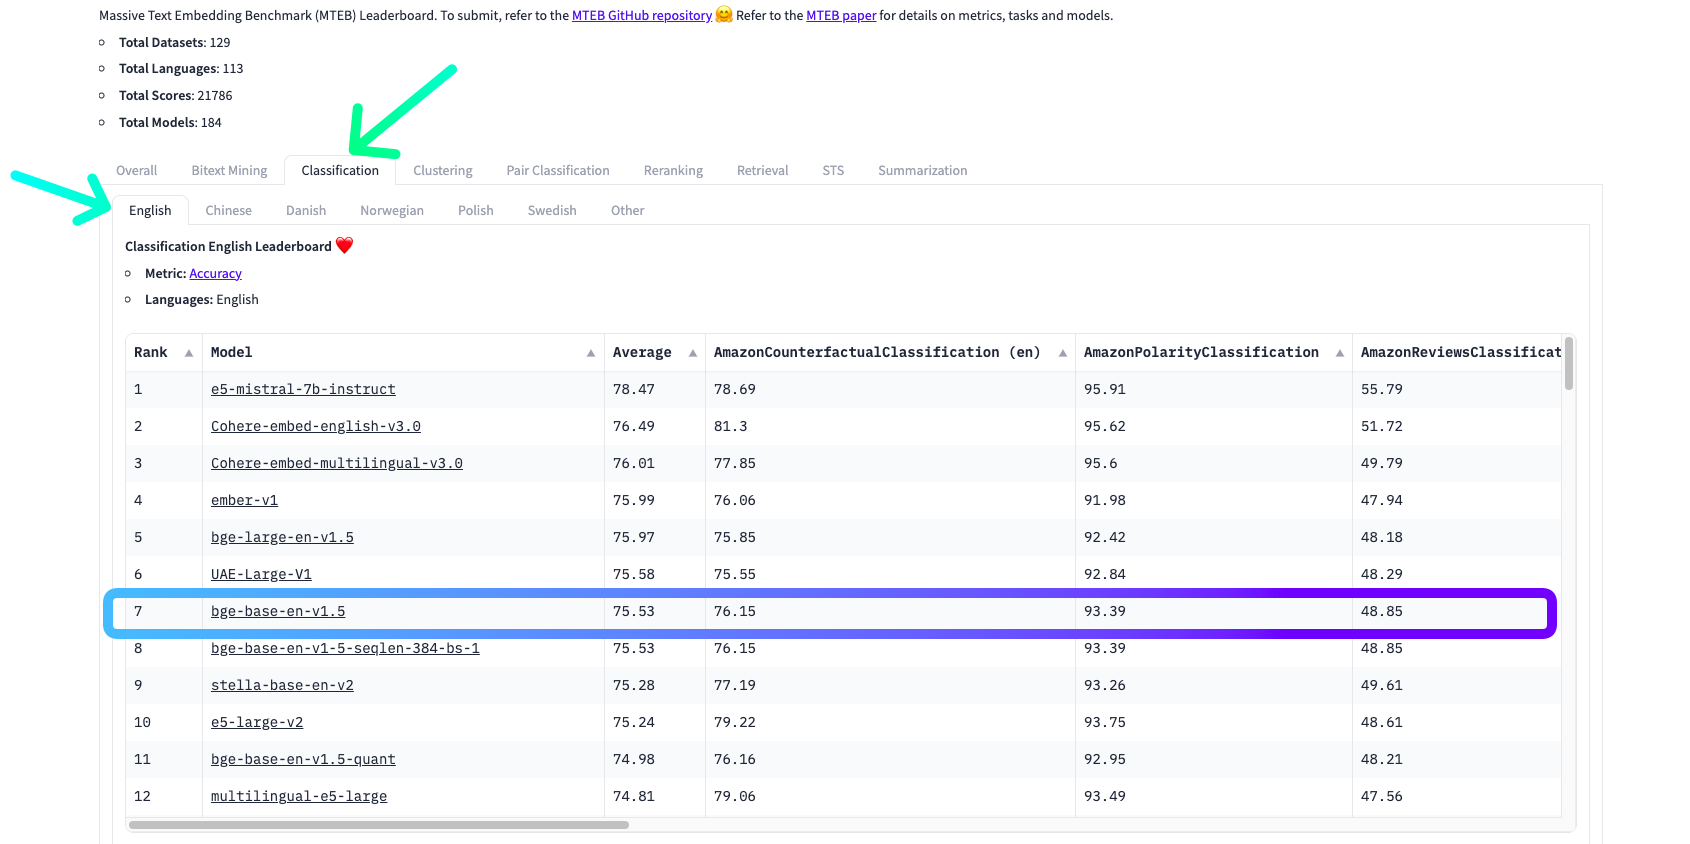

In [19]:
from transformers import AutoTokenizer, AutoModel
import torch


# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-base-en-v1.5')
model = AutoModel.from_pretrained('BAAI/bge-base-en-v1.5')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

J'effectue mon tokenzier, bien plus rapide que de le faire manuellement

In [20]:
sentences = df["description"].tolist()  

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt', max_length=512)

Je créer mon embeddings par produit

In [21]:
# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)
    # Perform pooling. In this case, cls pooling.
    sentence_embeddings = model_output[0][:, 0]

In [ ]:
X = sentence_embeddings
y = df["cat_e"]

In [ ]:
pca = PCA(n_components=0.99, random_state=42)
feat_pca= pca.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=120, random_state=42)
X_tsne = tsne.fit_transform(feat_pca)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tsne, y, test_size=0.3, random_state=42)

In [ ]:
# Initialize and train the RandomForest classifier  
clf = RandomForestClassifier(n_estimators=100, random_state=42)  
clf.fit(X_train, y_train)  

RandomForestClassifier(random_state=42)

In [ ]:
# Predict on the test set  
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)  
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.51%


Précision de 96.51%, excellent!

## Image

J'utilise paperswithcode pour voir la classification d'images

https://paperswithcode.com/task/image-classification

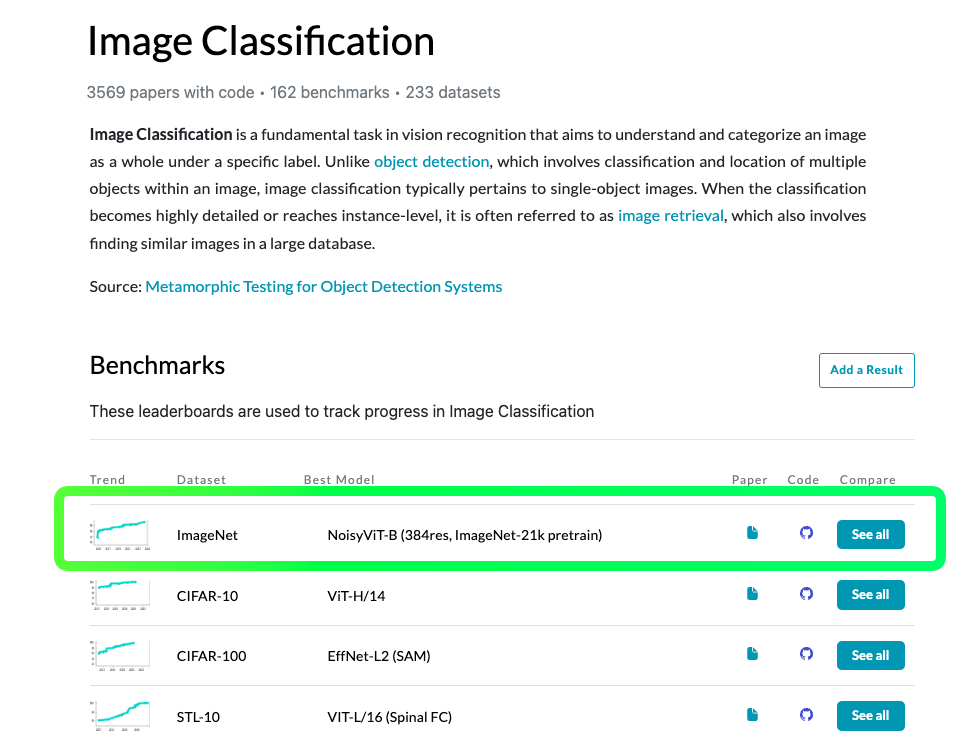

J'essaye de prendre quelque chose que pourra prendre en charge mon PC, je filtre à imageNet-1k.
Et je décide d'observer Hiera-H de facebook

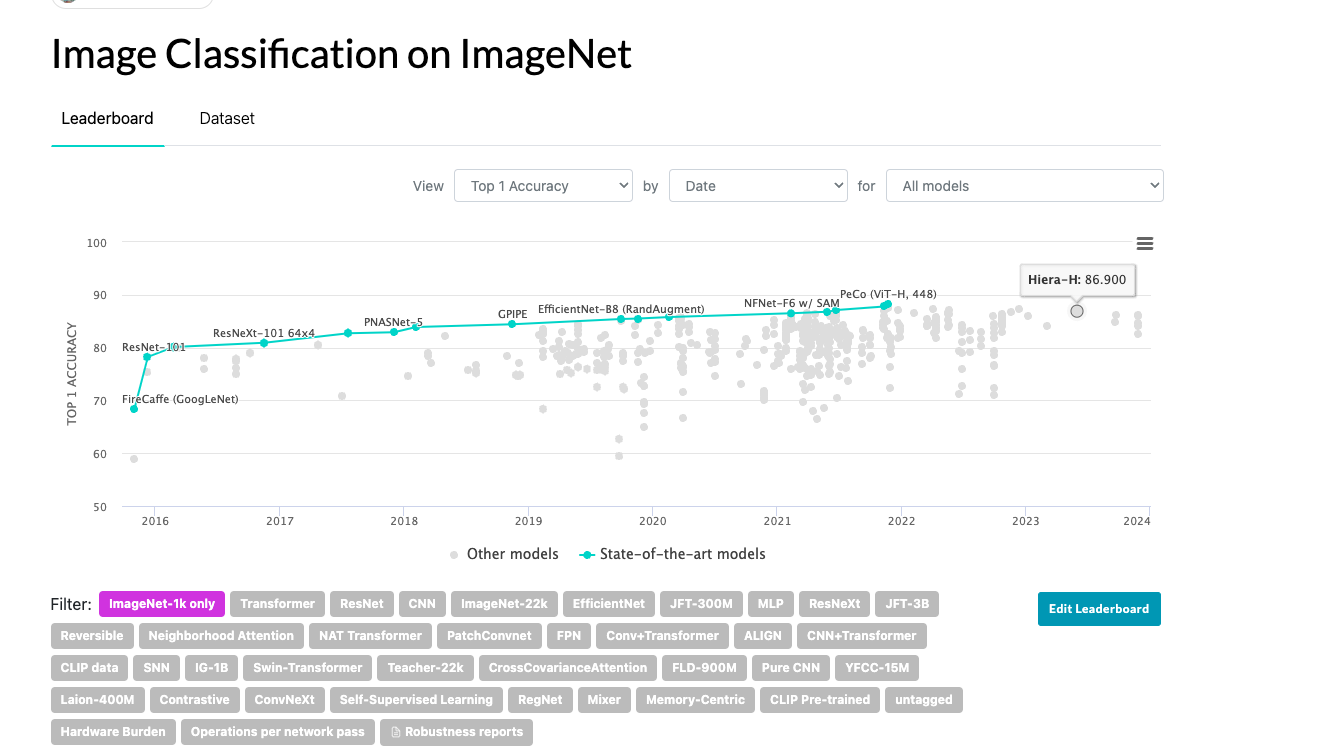

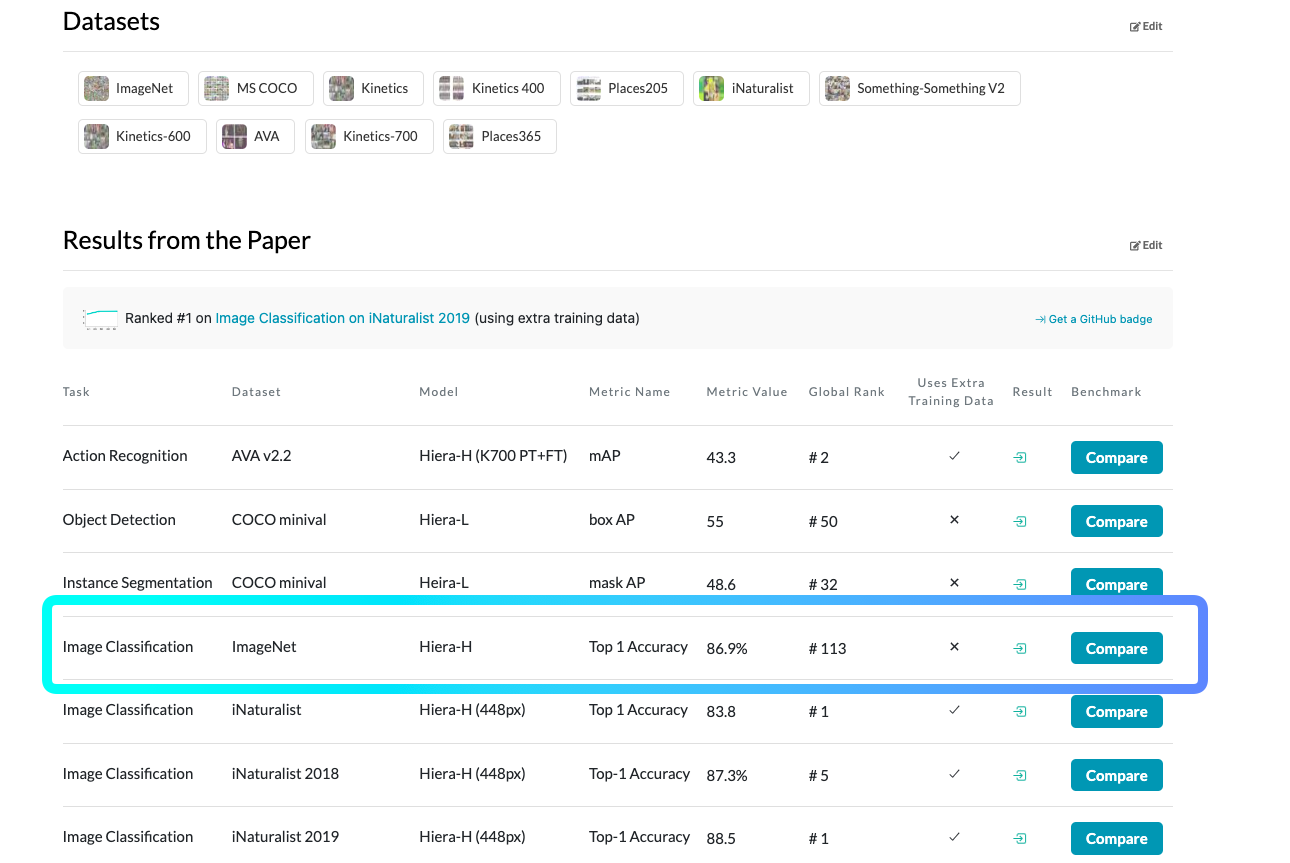

Je prends la version moins avancé pour mon PC mais pour pouvoir tout de même tester

In [ ]:
# Smaller model implementation
model = torch.hub.load("facebookresearch/hiera", model="hiera_base_224", pretrained=True, checkpoint="mae_in1k_ft_in1k")  

Downloading: "https://github.com/facebookresearch/hiera/zipball/main" to /Users/m/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/hiera/hiera_base_224.pth" to /Users/m/.cache/torch/hub/checkpoints/hiera_base_224.pth
100%|██████████| 590M/590M [00:24<00:00, 25.6MB/s] 


In [ ]:
model.eval()

Hiera(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  )
  (unroll): Unroll()
  (reroll): Reroll()
  (blocks): ModuleList(
    (0-1): 2 x HieraBlock(
      (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (attn): MaskUnitAttention(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (proj): Linear(in_features=96, out_features=96, bias=True)
      )
      (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=384, out_features=96, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
    )
    (2): HieraBlock(
      (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (attn): MaskUnitAttention(


Je transforme mes images

In [ ]:
# Define the image transformations that were used when the model was trained  
preprocess = transforms.Compose([  
    transforms.Resize(256),  
    transforms.CenterCrop(224),  
    transforms.ToTensor(),  
])

In [ ]:
# Feature extraction function  
def extract_features(img_path, model, preprocess):  
    input_image = Image.open(img_path).convert('RGB')  
    input_tensor = preprocess(input_image)  
    input_batch = input_tensor.unsqueeze(0)  # Add batch dimension  
  
    with torch.no_grad():  
        features = model(input_batch)  
      
    return features[0]  
  

In [ ]:
# Extract features for each image  
features = []
for img_path in tqdm(df['img_path'], desc="Extracting features"):  
    features.append(extract_features(img_path, model, preprocess).numpy())  


Extracting features:  64%|██████▍   | 677/1050 [00:56<00:31, 11.98it/s]/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Extracting features: 100%|██████████| 1050/1050 [01:30<00:00, 11.58it/s]


In [ ]:
labels = df['cat_e'].values  
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)  

In [ ]:
# Initialize and train the RandomForest classifier  
clf = RandomForestClassifier(n_estimators=100, random_state=42)  
clf.fit(X_train, y_train)  

# Predict on the test set  
y_pred = clf.predict(X_test)

# Calculate accuracy  
accuracy = accuracy_score(y_test, y_pred)  
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 80.95%


Pas mal en non supervisé

## Test avec un autre modèle de chez Google 
Ne fonctionne pas car machine local pas assez puissante.

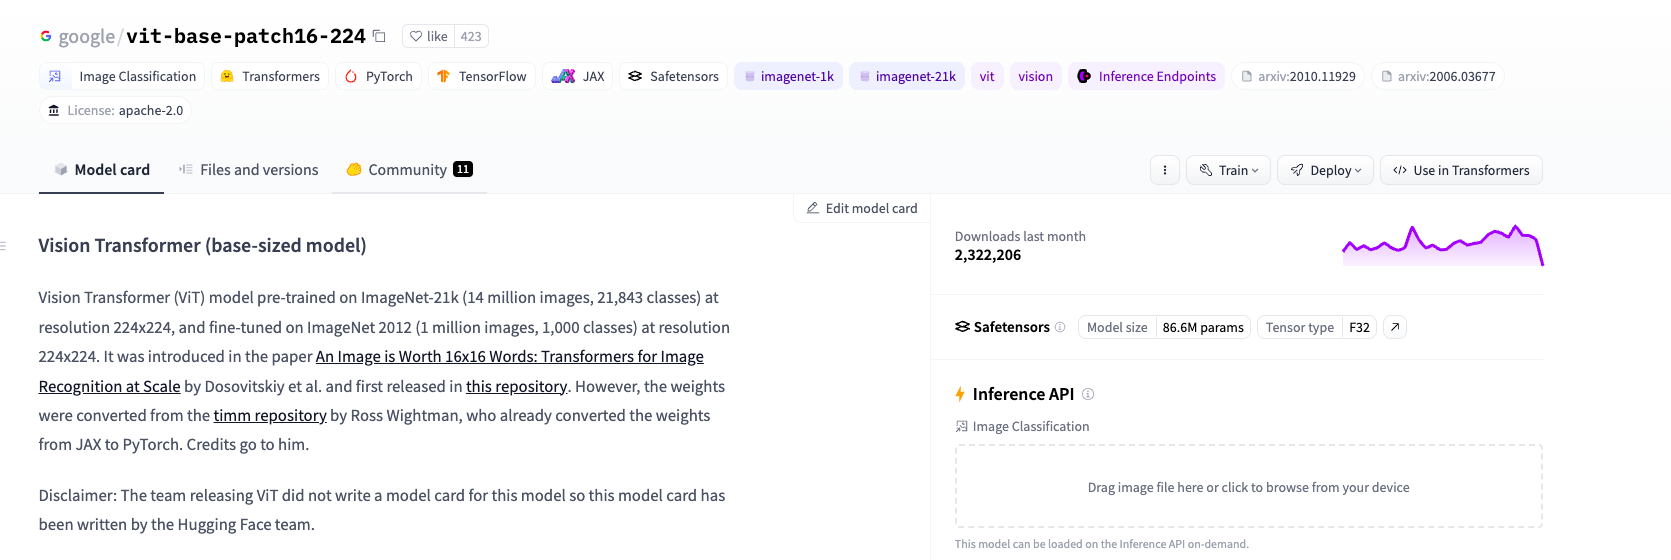

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits


# # model predicts one of the 1000 ImageNet classes
# predicted_class_idx = logits.argmax(-1).item()
# print("Predicted class:", predicted_class_idx)

In [ ]:
# Feature extraction function  
def extract_features_v2(img_path, model):  
    input_image = Image.open(img_path).convert('RGB')  
    inputs = processor(images=input_image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    
    return logits[0]
  

In [ ]:
# Extract features for each image  
features_v2 = []
for img_path in tqdm(df['img_path'], desc="Extracting features"):  
    features_v2.append(extract_features_v2(img_path, model))  


Extracting features:  38%|███▊      | 402/1050 [00:56<01:21,  7.90it/s]

: 

In [ ]:
# labels = df['cat_e'].values  
# X_train, X_test, y_train, y_test = train_test_split(features_v2, labels, test_size=0.2, random_state=42)  

In [ ]:
# # Initialize and train the RandomForest classifier  
# clf = RandomForestClassifier(n_estimators=100, random_state=42)  
# clf.fit(X_train, y_train)  

# # Predict on the test set  
# y_pred = clf.predict(X_test)

# # Calculate accuracy  
# accuracy = accuracy_score(y_test, y_pred)  
# print(f"Accuracy: {accuracy * 100:.2f}%")